In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/alvra_tools/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

pede_file = "/das/work/p17/p17983/Example_data/res/JF_pedestals/pedestal_20190706_1050.JF02T09V02.res.h5"

gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]

print("Dimensions of G: ", G.shape)
print("Dimensions of P: ", P.shape)
print("Dimensions of mask: ", mask.shape)

# Detector name for loading module map and applying geometry
detector_name = "JF02T09V02"

Dimensions of G:  (4, 4608, 1024)
Dimensions of P:  (4, 4608, 1024)
Dimensions of mask:  (4608, 1024)


In [4]:
DIR = "/das/work/p17/p17983/Example_data/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/"

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

There are 244 files in the folder /das/work/p17/p17983/Example_data/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/


In [5]:
filename = "Febpy_monoscan_200mJ_5ps_001_step0060.JF02T09V02.h5"
bsreadfile = "Febpy_monoscan_200mJ_5ps_001_step0060.BSREAD.h5"

images_off, images_on, pulse_ids_off, pulse_ids_on = load_JF_data_on_off(DIR + filename, 50, 25, nshots=None)
(DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, BS_pulse_ids_pump, BS_pulse_ids_unpump, _, _) = \
         load_PumpProbe_events(DIR+bsreadfile, channel_BS_pulse_ids)

Right now it seems like the on and off data is flipped coming from the load_JF_data_on_off function.  Will need to fix this.  For now I am just coding is backwards.

In [6]:
nframes = images_on.shape[0]
print('number of frames')
print(nframes)
#nframes = 50

X = [a==b and c==d for a,b,c,d in zip(pulse_ids_on, BS_pulse_ids_pump, pulse_ids_off, BS_pulse_ids_unpump)]
if sum([int(x) for x in X]) == images_on.shape[0]:
    print('passed pulse id check')
else:
    print('failed pulse id check')


number of frames
500
passed pulse id check


<IPython.core.display.Javascript object>


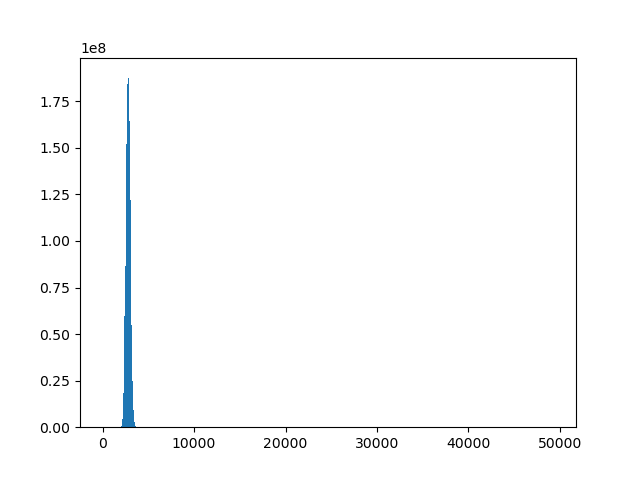

In [7]:
plt.figure()
_ = plt.hist(np.ndarray.flatten(images_off),1000)

In [8]:
numstds = 2
minIzero = 0.002
image_threshold = 4
hot_pixel = 4000

total_on = 0
total_off = 0

IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))

for i in range(nframes):
    
    conditionPumpMax = IzeroFEL_pump[i] < IzeroMedian+numstds*IzeroSTD
    conditionPumpMin = IzeroFEL_pump[i] > IzeroMedian-numstds*IzeroSTD
    conditionPumpLow = IzeroFEL_pump[i] > minIzero
    
    if conditionPumpMax and conditionPumpMin and conditionPumpLow:

        image_on = images_on[i, :]
        image_on = ju.apply_gain_pede(image_on, G=G, P=P, pixel_mask=mask, highgain=False)
        image_on_thr = image_on.copy()
        image_on_thr[image_on < image_threshold] = 0
        image_on_thr[image_on > hot_pixel] = 0
        total_on += image_on_thr/IzeroFEL_pump[i]
    
    conditionUnPumpMax = IzeroFEL_unpump[i] < IzeroMedian+numstds*IzeroSTD
    conditionUnPumpMin = IzeroFEL_unpump[i] > IzeroMedian-numstds*IzeroSTD
    conditionUnPumpLow = IzeroFEL_unpump[i] > minIzero
    
    if conditionUnPumpMax and conditionUnPumpMin and conditionUnPumpLow:
        
        image_off = images_off[i, :]
        image_off = ju.apply_gain_pede(image_off, G=G, P=P, pixel_mask=mask, highgain=False)
        image_off_thr = image_off.copy()
        image_off_thr[image_off < image_threshold] = 0
        image_off_thr[image_off > hot_pixel] = 0
        total_off += image_off_thr/IzeroFEL_unpump[i]

total_on_corr = ju.apply_geometry(total_on, detector_name)
total_off_corr = ju.apply_geometry(total_off, detector_name)

print(total_on_corr.shape)
print(total_off_corr.shape)


(514, 9318)
(514, 9318)


78.77628079465802
80886384.35899185


<IPython.core.display.Javascript object>


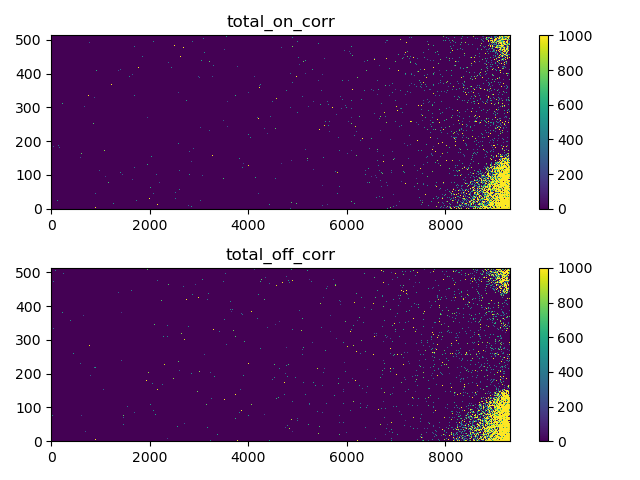

In [9]:
print(np.mean(np.ndarray.flatten(total_on_corr)))
print(max(np.ndarray.flatten(total_on_corr)))

plt.figure()
plt.subplots_adjust(wspace=100)
plt.subplot(211)
plt.imshow(total_on_corr, origin="lower", aspect='auto', vmin=0, vmax=1000)
plt.colorbar()
plt.title('total_on_corr')
plt.subplot(212)
plt.imshow(total_off_corr, origin="lower", aspect='auto', vmin=0, vmax=1000)
plt.colorbar()
plt.title('total_off_corr')
plt.tight_layout()
plt.show()


9318
(514, 9318)


<IPython.core.display.Javascript object>


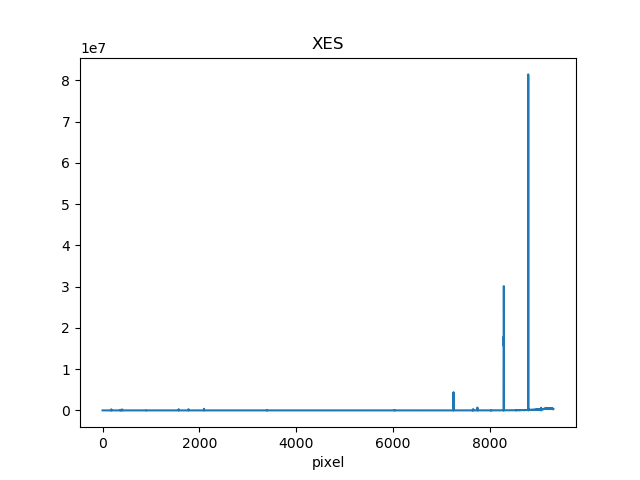

9318
(514, 9318)


<IPython.core.display.Javascript object>


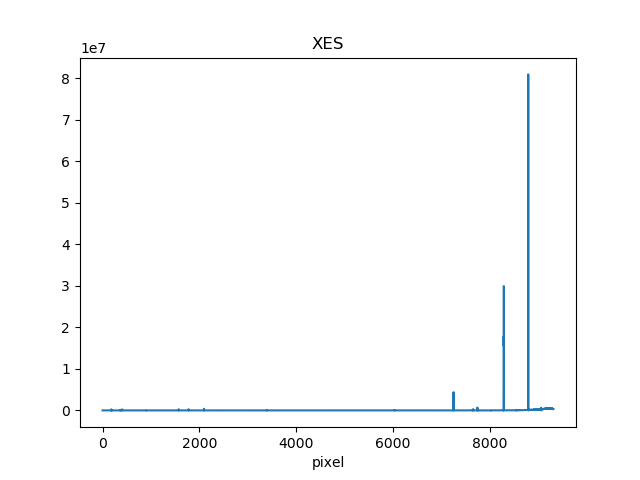

<IPython.core.display.Javascript object>


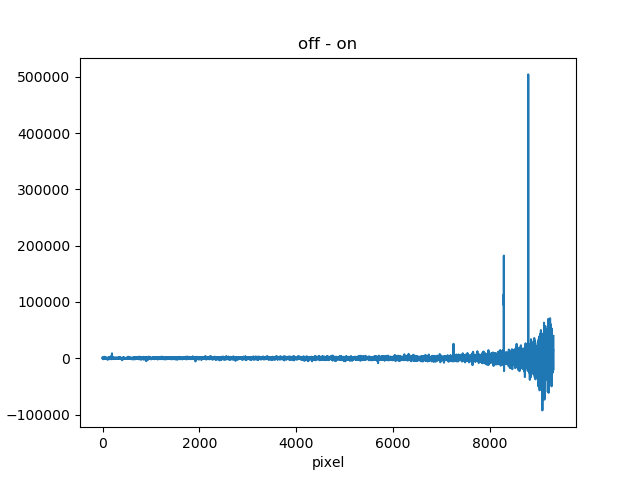

Text(0.5, 1.0, 'off - on')

In [10]:
XES_off = np.sum(total_off_corr,axis=0)
print(XES_off.size)
print(total_off_corr.shape)

plt.figure()
plt.plot(XES_off)
plt.xlabel('pixel')
plt.title('XES')

XES_on = np.sum(total_on_corr,axis=0)
print(XES_on.size)
print(total_on_corr.shape)

plt.figure()
plt.plot(XES_on)
plt.xlabel('pixel')
plt.title('XES')

plt.figure()
plt.plot(XES_off-XES_on)
plt.xlabel('pixel')
plt.title('off - on')

